**Course website**: http://www.leouieda.com/geofisica1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Prática 2 - Transformada de Fourier e transformações da anomalia

Objetivos:

* Visualizar os efeitos e resultados da Transformada de Fourier em sinais simples.
* Aplicar a Transformada de Fourier para calcular derivadas da anomalia magnética de campo total.
* Observar os efeitos do erro aleatório nas derivadas calculadas.
* Aprender as utilidades e limites da continuação para cima e da redução ao polo.

## Preparação

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc). Esta prática usará a biblioteca [Fatiando a Terra](http://fatiando.org) de modelagem geofísica e também o módulo [numpy](http://www.numpy.org/).

O notebook é divido em células (como esta). Para editar o conteúdo de uma célula, clique nela (clique nesta para editar esse texto). Para executar uma célula, aperte `Shift + Enter`. Execute as duas células abaixo.

In [1]:
%matplotlib inline
from __future__ import division
from IPython.html import widgets
import numpy as np
from fatiando.gravmag import prism, fourier
from fatiando import utils, gridder, mesher
from fatiando.vis import mpl
import fatiando
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=12)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
print('Versão do Fatiando a Terra: {}'.format(fatiando.__version__))

Versão do Fatiando a Terra: 0.3-237-g65602ba


## Tarefa 1: Tranformada de Fourier de funções simples

A primeira tarefa servirá para ilustrar o conceito de [Transformada de Fourier](http://en.wikipedia.org/wiki/Fourier_transform) que vimos na aula teórica.

Como vimos em aula, uma função contínua pode ser escrita como:

$$
h(t) = \int\limits_{-\infty}^{\infty} H(f)\ e^{i 2 \pi f t}df
$$

em que $f$ é a frequência e $e^{i 2 \pi f t}$ são "coisas" que oscilam com frequência $f$.
A equação acima nos diz que a função $h(t)$ pode ser escrita como uma "soma" infinita de oscilações de frequências diferentes.
A oscilação de frequência $f$ é ponderada por uma amplitude $H(f)$. A função que descreve as amplitudes, $H(f)$, é a Transformada de Fourier:

$$
H(f) = \int\limits_{-\infty}^{\infty} h(t)\ e^{-i 2 \pi f t}dt
$$

$H(f)$ é um número complexo. É comum fazer um gráfico do módulo da transformada ($|H(f)|$) pela frequência. Esse gráfico é chamado de **espectro de amplitudes**.

**Rode a célula abaixo para gerar uma figura interativa.**

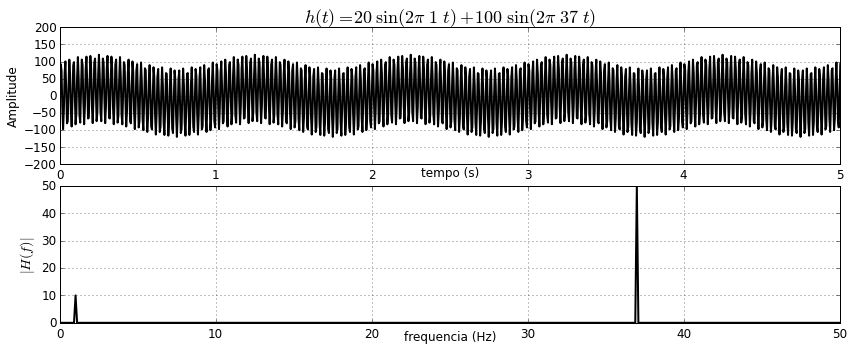

In [3]:
def dois_senos(freq1, amp1, freq2, amp2):
    sample = 1/200
    t = np.arange(0, 10, sample)
    n = t.size
    s = amp1*np.sin(2*np.pi*freq1*t) + amp2*np.sin(2*np.pi*freq2*t)
    f = np.fft.fftfreq(n, sample)[:n//2]
    S = np.fft.fft(s)[:n//2]/n
    fig = mpl.figure(figsize=(12, 5))
    ax = mpl.subplot(211)
    mpl.title(r'$h(t) = {:.0f}\ \sin(2\pi\ {:.0f}\ t) + {:.0f}\ \sin(2\pi\ {:.0f}\ t)$'.format(amp1, freq1, amp2, freq2),
              fontsize=18)
    mpl.plot(t, s, '-k')
    mpl.xlim(0, 5)
    mpl.ylim(-200, 200)
    mpl.grid()
    ax.set_xlabel('tempo (s)', labelpad=-15)
    mpl.ylabel('Amplitude')
    ax = mpl.subplot(212)
    mpl.plot(f, np.abs(S), '-k')
    mpl.xlim(0, 50)
    mpl.ylim(0, 50)
    mpl.grid()
    ax.set_xlabel('frequencia (Hz)', labelpad=-10)
    mpl.ylabel(r'$|H(f)|$', fontsize=14)
    mpl.tight_layout(h_pad=0)
widgets.interactive(dois_senos, 
                    freq1=widgets.IntSliderWidget(min=1, max=40, step=1, value=1), 
                    amp1=widgets.IntSliderWidget(min=0, max=100, step=10, value=0), 
                    freq2=widgets.IntSliderWidget(min=1, max=40, step=1, value=1), 
                    amp2=widgets.IntSliderWidget(min=0, max=100, step=10, value=100))

### Sobre a figura

* A figura de **cima** mostra a função $h(t)$ que é composta por dois senos.
* Os **botões** controlam a amplitude e frequência de cada seno.
* A figura de **baixo** mostra o espectro de amplitudes da função $h(t)$.

### Tarefas e perguntas

1. Deixe `amp1 = 0` e fixe `freq2` em algum valor. Varie somente `amp2`.
    * Por que o espectro de amplitudes é zero em todas as frequências exceto uma? Qual é essa frequência?
    * O que acontece com $h(t)$ e o espectro de amplitudes quando `amp2` varia?
2. Deixe `amp1 = 0` e `amp2=100`. Aumente `freq2`.
    * O que acontece com $h(t)$? A amplitude do seno muda?
    * O que acontece com o especro de amplitudes? A amplitude do espectro aumenta?
3. Deixe `amp2 = 100` e `freq2=1`. Aumente `amp1` e `freq1`.
    * O que acontece com $h(t)$ e o espectro de amplitudes?
    * Quais são as frequências que não tem amplitude zero no espectro?

## Tarefa 2: Continuação para cima

A Transformada de Fourier é muito útil na geofísica para fazer transformações nos dados. Em gravimetria e magnetometria, uma transformação comum é a "continuação para cima". Essa transformação nos permite calcular como a anomalia medida seria se estivesse a uma altitude maior. Um dos jeitos de calcular a continuação é através da transformada de Fourier.

**Rode a célula abaixo para gerar uma figura interativa.**

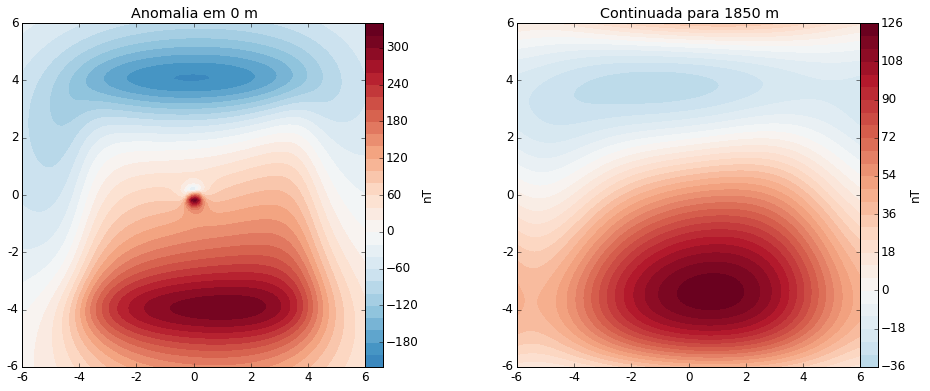

In [4]:
shape = (100, 100)
x, y, z = gridder.regular((-6000, 6000, -6000, 6000), shape, z=0)
modelo = [mesher.Prism(-200, 200, -200, 200, 100, 500),
          mesher.Prism(-4000, 4000, -4000, 4000, 1000, 5000)]
inc, dec = 45, -10
mag = utils.ang2vec(1, inc, dec)
modelo[0].props['magnetization'] = 1*mag
modelo[1].props['magnetization'] = 1*mag
def continuacao(altitude, erro):
    cubo_area = modelo[0].get_bounds()[:4][::-1]
    tf = prism.tf(x, y, z, modelo, inc, dec)
    if erro > 0:
        tf = utils.contaminate(tf, erro, seed=0)
    cont = fourier.upcontinue(x, y, tf, shape, altitude)
    fig, axes = mpl.subplots(1, 2, figsize=(14, 5.5))
    for ax, data, title in zip(axes.ravel(), [tf, cont], ['Anomalia em 0 m', 'Continuada para {:.0f} m'.format(altitude)]):
        ax.set_aspect('equal')
        mpl.sca(ax)
        mpl.title(title)
        scale = np.abs([data.min(), data.max()]).max()
        mpl.contourf(y, x, data, shape, 30, cmap=mpl.cm.RdBu_r, vmin=-scale, vmax=scale)
        mpl.colorbar(pad=0).set_label('nT')
        mpl.m2km()
    mpl.tight_layout(h_pad=0, w_pad=0)    
widgets.interactive(continuacao, 
                    altitude=widgets.FloatSliderWidget(min=0, max=5000, step=50, value=0),
                    erro=widgets.FloatSliderWidget(min=0, max=20, step=1, value=0))

### Sobre a figura

* Os dados são a anomalia magnética de campo total gerada por dois corpos: um grande e fundo; outro raso e pequeno (no meio da figura).
* A figura da **esquerda** mostra a anomalia calulada a uma altitude de 0 m.
* A figura da **direita** mostra a anomalia continuada para uma altitude maior usando a Transformada de Fourier.
* Os **botões** controlam a altitude da continuação e o erro (em nanoTesla) colocado no dado original (da esquerda).

### Tarefas e perguntas

1. Deixe o erro em 0 nT. Aumente a altitude de continuação.
    * O que acontece com a forma e amplitude da anomalia continuada? Dica: observe a barra de cor.
    * As duas anomalias (grande e pequena) sofrem a mesma influência da continuação?
    * Se você quiser remover o efeito de uma das anomalias do seu dado, você poderia subtrair os dados da direta dos dados da esquerda? Ou seja, subtrair os dados continuados dos dados observados?
2. Aumente o erro e varie a altitude de continuação.
    * Como o erro afeta o resultado da continuação?

## Tarefa 3: Derivada total

Outra operação que a Transformada de Fourier nos permite fazer é calcular derivadas dos nossos dados. Uma transformação muito utilizada na magnetometria é a Derivada Total (DT):

$$
DT = \sqrt{\left(\frac{\partial T}{\partial x}\right)^2 + \left(\frac{\partial T}{\partial y}\right)^2 + \left(\frac{\partial T}{\partial z}\right)^2}
$$

A DT é famosa por concentrar a anomalia magnética de campo total sobre o corpo causador da anomalia.

As derivadas parciais na equação acima podem ser calculadas da anomalia de campo total ($T$) usando a Transformada de Fourier.
Derivando a equação de $h(t)$ acima:

$$
\frac{\partial h}{\partial t} = \frac{\partial}{\partial t}\left(\int\limits_{-\infty}^{\infty} H(f)\ e^{i 2 \pi f t}df\right)
$$

Como a única coisa que depende de $t$ é $e^{i 2 \pi f t}$, podemos passar a derivada para dentro da integral:

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} H(f)\ \frac{\partial e^{i 2 \pi f t}}{\partial t}df
$$

e aplicando a [regra da cadeia](http://en.wikipedia.org/wiki/Chain_rule)

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} H(f)\ i 2 \pi f\ e^{i 2 \pi f t} df
$$

$\frac{\partial h}{\partial t}$ também é uma função e pode ser escrita como a soma de infinitas oscilações. Se chamarmos a transformada de Fourier de uma função $h$ de $F\{h\}$, podemos escrever a derivada de $h$ como:

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} F\left\{\frac{\partial h}{\partial t}\right\}e^{i 2 \pi f t} df
$$

Se compararmos as duas equações acima, vemos que

$$
F\left\{\frac{\partial h}{\partial t}\right\} = H(f)\ i 2 \pi f
$$

Ou seja, a transformada de Fourier da derivada é $i 2 \pi f$ vezes a transformada de Fourier da função. Uma vez tendo a transformada da derivada, podemos calcular a derivada.

**Rode a célula abaixo para gerar uma figura interativa.**

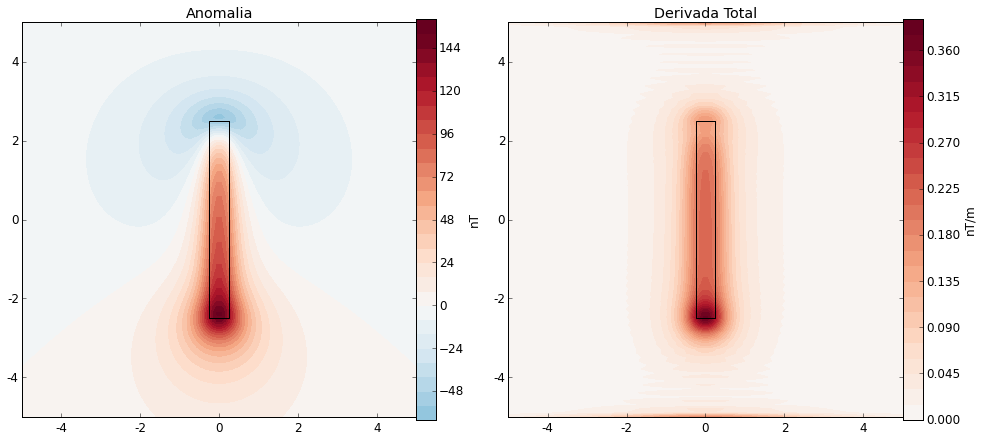

In [5]:
shape = (100, 100)
x, y, z = gridder.regular((-5000, 5000, -5000, 5000), shape, z=0)
dx, dy = 500, 5000
cubo = mesher.Prism(-dy/2, dy/2, -dx/2, dx/2, 400, 4000)
cubo_area = cubo.get_bounds()[:4][::-1]
def derivada_total(inc, dec, erro):
    tf = prism.tf(x, y, z, [cubo], inc, dec, pmag=utils.ang2vec(1, inc, dec))
    if erro > 0:
        tf = utils.contaminate(tf, erro, seed=0)
    total = fourier.ansig(x, y, tf, shape)
    fig, axes = mpl.subplots(1, 2, figsize=(14, 6))
    for ax, data, title in zip(axes.ravel(), [tf, total], ['Anomalia', 'Derivada Total']):
        ax.set_aspect('equal')
        mpl.sca(ax)
        mpl.title(title)
        mpl.square(cubo_area)
        scale = np.abs([data.min(), data.max()]).max()
        mpl.contourf(y, x, data, shape, 30, cmap=mpl.cm.RdBu_r, vmin=-scale, vmax=scale)
        if title != "Anomalia":
            mpl.colorbar(pad=0).set_label('nT/m')
        else:
            mpl.colorbar(pad=0).set_label('nT')                
        mpl.m2km()
    mpl.tight_layout(h_pad=0, w_pad=0)    
widgets.interactive(derivada_total, 
                    inc=widgets.IntSliderWidget(min=-90, max=90, step=5, value=45),
                    dec=widgets.IntSliderWidget(min=-90, max=90, step=5, value=0),
                    erro=widgets.FloatSliderWidget(min=0, max=20, step=1, value=0))

### Sobre a figura

* A figura da **esquerda** mostra a anomalia magnética de campo total causada por um paralelepípedo (contorno preto).
* A figura da **direita** mostra a derivada total (DT) da anomalia da esquerda calculada com a Transformada de Fourier.
* Os **botões** controlam a inclinação e declinação do campo da Terra (`inc` e `dec`) e o erro colocado nos dados originais (da esquerda).

### Tarefas e perguntas

1. Mantenha a inclinação em 45º e declinação em 0. Aumente o erro aplicado aos dados.
    * O que acontece com a Derivada Total quando o erro aumenta? Por que acontece isso? Dica: olhe as equações acima.
2. Varie a inclinação e a declinação.
    * A DT varia com a inclinação?
    * A DT continua concentrada em cima do corpo para qualquer inclinação?
    * Se a inclinação for 0, o que acontece com a DT quando a declinação varia até $\pm90$?

## Tarefa 4: Redução ao pólo

Vimos na [prática 1](http://www.leouieda.com/geofisica1/lessons/magnetometria/pratica1.html) que a anomalia magnética é muito complicada de interpretar. A melhor situação é quando a inclinação do campo magnético é $\pm90^\circ$ (nos polos). 

Felizmente, há um jeito de calcular como a anomalia que medimos ficaria se estivesse nos polos. A técnica chama-se (numa explosão de criatividade) "Redução ao Polo". Um dos jeitos de se calcular a redução ao polo é usando a transformada de Fourier.

**É necessário conhecer a direção de magnetização do corpo para aplicar a redução ao polo**. Isso é fácil se o corpo tiver somente magnetização induzida pelo campo geomagnético. A magnetização é paralela ao campo da Terra. A situação complica quando há magnetização remanente, aquela que os minerais ferromagnéticos guardam quando se resfriam abaixo da [temperatura de Curie](http://en.wikipedia.org/wiki/Curie_temperature). Por isso a redução ao polo não é tão facilmente utilizada quanto a Derivada Total.

**Rode a célula abaixo para gerar uma figura interativa.**

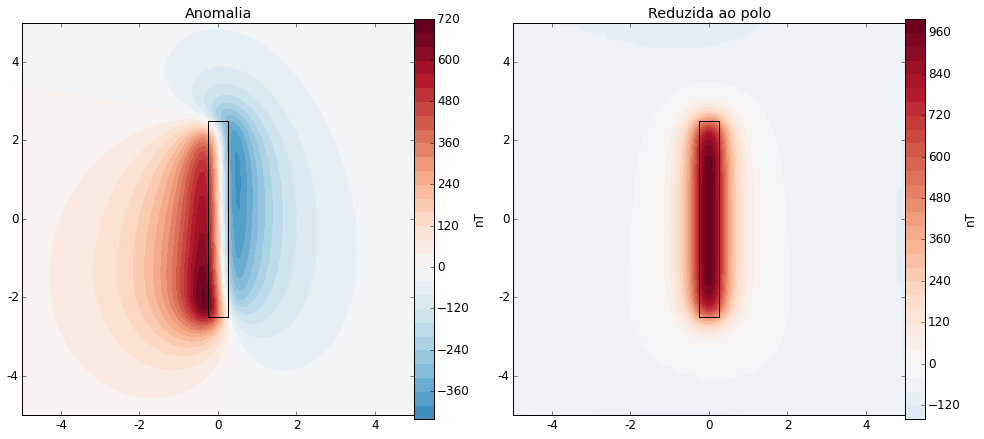

In [6]:
shape = (100, 100)
x, y, z = gridder.regular((-5000, 5000, -5000, 5000), shape, z=0)
dx, dy = 500, 5000
cubo = mesher.Prism(-dy/2, dy/2, -dx/2, dx/2, 400, 4000)
cubo_area = cubo.get_bounds()[:4][::-1]
def reducao_polo(inc, dec, erro):
    tf = prism.tf(x, y, z, [cubo], inc, dec, pmag=utils.ang2vec(5, inc, dec))
    if erro > 0:
        tf = utils.contaminate(tf, erro, seed=0)
    rtp = fourier.reduce_to_pole(x, y, tf, shape, inc, dec)
    fig, axes = mpl.subplots(1, 2, figsize=(14, 6))
    for ax, data, title in zip(axes.ravel(), [tf, rtp], ['Anomalia', 'Reduzida ao polo']):
        ax.set_aspect('equal')
        mpl.sca(ax)
        mpl.title(title)
        mpl.square(cubo_area)
        scale = np.abs([data.min(), data.max()]).max()
        mpl.contourf(y, x, data, shape, 30, cmap=mpl.cm.RdBu_r, vmin=-scale, vmax=scale)
        mpl.colorbar(pad=0).set_label('nT')
        mpl.m2km()
    mpl.tight_layout(h_pad=0, w_pad=0)    
widgets.interactive(reducao_polo, 
                    inc=widgets.IntSliderWidget(min=-90, max=90, step=5, value=45),
                    dec=widgets.IntSliderWidget(min=-90, max=90, step=5, value=0),
                    erro=widgets.FloatSliderWidget(min=0, max=20, step=1, value=0))

### Sobre a figura

* A figura da **esquerda** mostra a anomalia magnética de campo total causada por um paralelepípedo (contorno preto).
* A figura da **direita** mostra a anomalia reduzida ao polo (calculado com a Transformada de Fourier).
* Os **botões** controlam a inclinação e declinação do campo da Terra (`inc` e `dec`) e o erro colocado nos dados originais (da esquerda).

### Tarefas e perguntas

1. Mantenha a inclinação em 45º e declinação em 0. Aumente o erro aplicado aos dados.
    * O que acontece com a redução ao polo quando o erro aumenta? O efeito é tão grande quanto na Derivada Total?
2. Varie a declinação.
    * A anomalia reduzida ao polo continua concentrada em cima do corpo?
    * A qualidade da redução ao polo varia com a declinação?
3. Varie a inclinação
    * Como a qualidade da redução ao polo varia com a inclinação?
    * Quais limitações essa variabilidade impõe na aplicabilidade da redução ao polo?  